In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
import numpy as np

# 1. 导入数据集

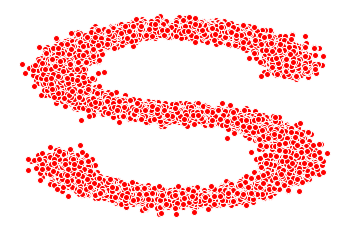

In [2]:
s_curve, _ = make_s_curve(10**4, noise=0.1)
# make_s_curve(n_samples, noise=0.1)
# make_s_curve表示生成S曲线的数据集，n_sample:样本点的数量, noise噪声偏移量
s_curve = s_curve[:, [0, 2]] / 10.0
data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color="red", edgecolors="white")
ax.axis("off")
dataset = torch.tensor(s_curve).float()

# 2 确定超参数的值
$$
\begin{aligned}
x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} z \\
\alpha_t &= 1 - \beta_t \\
\bar{\alpha}_T &= \alpha_1 * \alpha_2 * \cdots  * \alpha_T
\end{aligned}
$$
alphas_prod     : ${\bar{\alpha}_1, \bar{\alpha}_2, \cdots, \bar{\alpha}_T}$  
alphas_prod_p   : ${\bar{\alpha}_0, \bar{\alpha}_1, \cdots, \bar{\alpha}_{T-1}}$  
alphas_bar_sqrt : ${\sqrt{\bar{\alpha}_1}, \sqrt{\bar{\alpha}_2}, \cdots, \sqrt{\bar{\alpha}_{T}}}$  
one_minus_alphas_bars_log : $\ln{(1 - \bar{\alpha}_1)}, \ln{(1 - \bar{\alpha}_2)}, \cdots, \ln{(1 - \bar{\alpha}_T)}$  
one_minus_alphas_bars_sqrt: $\sqrt{1 - \bar{\alpha}_1}, \sqrt{1 - \bar{\alpha}_2}, \cdots, \sqrt{1 - \bar{\alpha}_T}$

In [3]:
num_step = 100
# 制定每一步的beta
betas = torch.linspace(-6, 6, num_step)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5   # betas的值一般比较小
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0) 
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bars_log = torch.log(1 - alphas_prod)
one_minus_alphas_bars_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bars_log.shape == one_minus_alphas_bars_sqrt.shape
print(f"all the same shape:{alphas.shape}")

all the same shape:torch.Size([100])


# 3 确定扩散过程任意时刻的任意时刻的采样值
$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\bar{z}_t
$$

In [4]:
def q_x(x_0, t):
    """
        基于 x_0 得到任意时刻的t的 x_t
    """
    noise = torch.randn_like(x_0, device=x_0.device)
    return  alphas_bar_sqrt[t] * x_0 + one_minus_alphas_bars_sqrt[t] * noise
    

# 4 显示原始数据分布加噪100步之后的效果

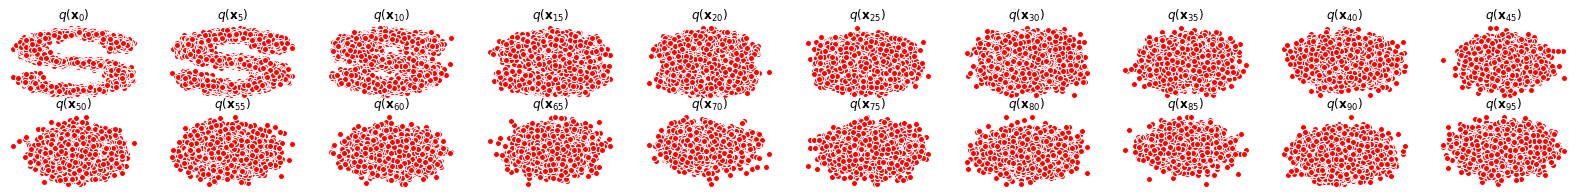

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc("text", color="white")
for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i*num_step//num_shows])) # num_step = 100 
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color="red", edgecolor="white")
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i * 5)+'})$')

# 5 逆扩散过程

In [6]:
import torch.nn as nn
class MLPDiffusion(nn.Module):
    def __init__(self, num_step, num_units=128) -> None:
        super().__init__()
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        # nn.sequential()和nn.ModuleList()的区别：
        # nn.Sequential()里面的模块有先后顺序， nn.ModuleList()里面的模块并没有先后顺序
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(num_step, num_units),
                nn.Embedding(num_step, num_units),
                nn.Embedding(num_step, num_units),
            ]
        )
        
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx + 1](x)
        
        x = self.linears[-1](x)
        return x

# 6 编写误差函数
$$
L_{simple}(\theta) := \mathbb{E}_{t, x_0, \epsilon} [|| \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t) ||]
$$ 

In [7]:
def diffusion_loss_fn(model:nn.Module, x_0:torch.TensorType, alphas_bar_sqrt:torch.TensorType, 
                      one_minus_alphas_bar_sqrt:torch.TensorType, n_steps:int):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    device = x_0.device
    t = torch.randint(0, n_steps, size=(batch_size//2,), device=device)    # ????
    t = torch.cat([t, n_steps-1-t], dim=0)                  # ????
    t = t.unsqueeze(-1)
    epsilon = torch.randn_like(x_0, device=device)
    x = x_0 * alphas_bar_sqrt[t] + one_minus_alphas_bar_sqrt[t] * epsilon
    output = model(x, t.squeeze(-1))
    return (epsilon - output).square().mean()

# 7 逆扩散采样函数(inference过程)
$$
\mu_\theta\left(x_t, t\right)=\frac{1}{\sqrt{a_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{a}_t}} \epsilon_\theta\left(x_t, t\right)\right)\\
\Sigma_\theta(x_t, t) = \beta_t 
$$

In [8]:
def p_sample_loop(model:nn.Module, shape:tuple, num_step:int, betas:torch.TensorType, 
                  one_minus_alphas_bars_sqrt:torch.TensorType, device:"cuda"):
    """从x_T恢复x_{T-1}, x_{T-2}, ..., x_0"""
    cur_x = torch.randn(shape, device=device)
    x_seq = [cur_x]
    for i in reversed(range(num_step)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bars_sqrt)
        x_seq.append(cur_x)
    return x_seq
    
def p_sample(model:nn.Module, x:torch.TensorType, t:int, betas:torch.TensorType, one_minus_alphas_bars_sqrt:torch.TensorType):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t], device=x.device)
    coeff = betas[t] / one_minus_alphas_bars_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t])).sqrt() * (x - (coeff * eps_theta))
    z = torch.randn_like(x, device=x.device)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

# 8 训练模型,并打印loss及中间的重构效果

In [10]:
seed = 1212
class EMA(nn.Module):
    """构建一个参数平滑器"""
    def __init__(self, mu=0.01) -> None:
        super().__init__()
        self.mu = mu
        self.shadow = {}
    
    def register(self, name, val):
        self.shadow[name] = val.clone()
    
    def __cal__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
betas = betas.to(device)
one_minus_alphas_bars_sqrt = one_minus_alphas_bars_sqrt.to(device)
print("Trainning model...")

batchsize = 128
dataloader = torch.utils.data.DataLoader(dataset, batchsize, shuffle=True)
num_epoch = 4000
plt.rc('text', color='white')

model = MLPDiffusion(num_step).to(device)
optimer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x.to(device), alphas_bar_sqrt.to(device), one_minus_alphas_bars_sqrt.to(device), num_step)
        optimer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimer.step()
    
    if t % 100 == 0:   
        print(f"epoch:{t} || loss:{loss.item()}")
        x_seq = p_sample_loop(model, dataset.shape, num_step, betas, one_minus_alphas_bars_sqrt,device=device)
        
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().cpu()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolors="white")
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i * 10)+'})$')
                

Trainning model...
epoch:0 || loss:0.6123665571212769
epoch:100 || loss:0.2594152092933655
epoch:200 || loss:0.24503430724143982
epoch:300 || loss:0.24493788182735443
epoch:400 || loss:0.27901068329811096
epoch:500 || loss:0.28194382786750793
epoch:600 || loss:0.35932499170303345
epoch:700 || loss:0.3393305540084839
epoch:800 || loss:0.28899073600769043
epoch:900 || loss:0.4091370105743408
epoch:1000 || loss:0.203256756067276
epoch:1100 || loss:0.38313430547714233
epoch:1200 || loss:0.4576931893825531
epoch:1300 || loss:0.23362505435943604
epoch:1400 || loss:0.35901305079460144
epoch:1500 || loss:0.45992517471313477
epoch:1600 || loss:0.21874269843101501
epoch:1700 || loss:0.3184347152709961
epoch:1800 || loss:0.22417663037776947
epoch:1900 || loss:0.7822585105895996
epoch:2000 || loss:0.47620782256126404


C:\Users\zengx\AppData\Local\Temp\ipykernel_21932\3111095546.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


epoch:2100 || loss:0.4721786379814148
epoch:2200 || loss:0.30194562673568726
epoch:2300 || loss:0.255739688873291
epoch:2400 || loss:0.4469771981239319
epoch:2500 || loss:0.16200050711631775
epoch:2600 || loss:0.3991280198097229
epoch:2700 || loss:0.3990691304206848
epoch:2800 || loss:0.2609037756919861
epoch:2900 || loss:0.3621482253074646
epoch:3000 || loss:0.16219042241573334
epoch:3100 || loss:0.27365046739578247
epoch:3200 || loss:0.30908453464508057
epoch:3300 || loss:0.38449805974960327
epoch:3400 || loss:0.6204285025596619
epoch:3500 || loss:0.27439355850219727
epoch:3600 || loss:0.3992423415184021
epoch:3700 || loss:0.47565171122550964
epoch:3800 || loss:0.6271629333496094
epoch:3900 || loss:0.2980838418006897


In [ ]:
torch.save(model, "diffusion_demo.pth")

# 使用训练过的模型进行推断

In [ ]:
device = torch.device("cpu")
model_trained = torch.load("diffusion_demo.pth").to(device)
x_seq = p_sample_loop(model_trained, dataset.shape, num_step, betas, one_minus_alphas_bars_sqrt,device=device)

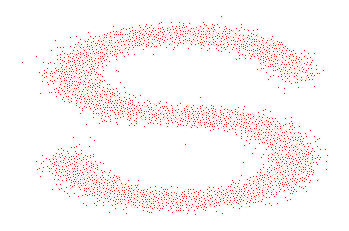

In [ ]:
import io 
from PIL import Image
imgs = []

for i in range(100):
    plt.clf()       # 清除当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0],  q_i[:, 1], color='red', edgecolors="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

reverse = []
for i in range(1,101):
    plt.clf()       # 清除当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
    cur_x = x_seq[i].detach().cpu()
    plt.scatter(cur_x[:, 0],  cur_x[:, 1], color='red', edgecolors="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)
    
imgs = imgs + reverse
imgs[0].save("diffusion.gif", format="GIF", append_images=imgs, save_all=True, duration=100, loop=0)